# XAI - TME 9 - Concept-Based Explanations

In [84]:
from torchtext.datasets import AG_NEWS
import torchdata
import torch, torchtext, torchdata
import numpy as np
import pandas as pd
import portalocker
import spacy
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Load AG News data
train_iter = AG_NEWS(split='train')
test_iter = AG_NEWS(split='test')

# preview
for i, (label, text) in enumerate(train_iter):
    print(label, text)
    if i >= 2:
        break

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
3 Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
3 Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.


/home/marilynch/mind/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [5]:
# tokenizing

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# list of all texts
texts = [text for _, text in train_iter][:10000]
# SpaCy processes in batches
docs = list(nlp.pipe(texts, batch_size=2000))


"""
tokens_list = []

for doc in docs:
    for token in doc:
        if not token.is_punct:
            tokens_list.append(token.text.lower())

print(len(tokens_list))
"""

In [14]:
# tokens to embeddings

embeddings = []

for doc in docs:
    # skip punctuation and OOV words without vectors
    token_vectors = []
    for token in doc:
        if not token.is_punct and token.has_vector:
            token_vectors.append(token.vector)
    
    doc_embedding = np.mean(token_vectors, axis=0)
    embeddings.append(doc_embedding)

embeddings = np.array(embeddings)
print("Shape of embeddings:", embeddings.shape)  # == (num_texts, vector_dim)

Shape of embeddings: (10000, 96)


**We're going to look at the importance of the concept 'World' on the prediction of the class 'Business'**

In [36]:
# concept vs random datasets:

X_train = embeddings
# get corresponding labels
y_train = np.array([label for label, _ in train_iter][:len(X_train)])

# concept sets - indeces of elements that correspond to each class
world_idx = [i for i, label in enumerate(y_train) if label == 1] 
sports_idx = [i for i, label in enumerate(y_train) if label == 2]
business_idx = [i for i, label in enumerate(y_train) if label == 3]  
scitech_idx = [i for i, label in enumerate(y_train) if label == 4] 

# we take target class == world
X_concept = X_train[world_idx]
X_randoms = np.vstack([X_train[sports_idx], X_train[business_idx], X_train[scitech_idx]])

# convert data to tensors
X_concept_tensor = torch.tensor(X_concept, dtype=torch.float32)
X_random_tensor = torch.tensor(X_randoms, dtype=torch.float32)

# labels: concept=1, random=0
y_concept = torch.ones(X_concept_tensor.shape[0], dtype=torch.float32)
y_random = torch.zeros(X_random_tensor.shape[0], dtype=torch.float32)

# concept dataloader
batch_size = 64
dataset_concept = TensorDataset(X_concept_tensor, y_concept)
dataloader_concept = DataLoader(dataset_concept, batch_size=batch_size, shuffle=True)

# randoms dataloader
dataset_random = TensorDataset(X_random_tensor, y_random)
dataloader_random = DataLoader(dataset_random, batch_size=batch_size, shuffle=True)

In [48]:
# classifier f dataset:

X_train = embeddings
# get corresponding labels
y_train = np.array([label for label, _ in train_iter][:len(X_train)])

# concept sets - indeces of elements that correspond to each class
world_idx = [i for i, label in enumerate(y_train) if label == 1] 
sports_idx = [i for i, label in enumerate(y_train) if label == 2]
business_idx = [i for i, label in enumerate(y_train) if label == 3]  
scitech_idx = [i for i, label in enumerate(y_train) if label == 4] 

# we take target class == world
X_target = X_train[business_idx]
X_randoms = np.vstack([X_train[sports_idx], X_train[world_idx], X_train[scitech_idx]])

# labels for classifier
y_target = np.ones(len(X_target))  
y_random  = np.zeros(len(X_randoms))

# combine data
X_classifier = torch.tensor(np.vstack([X_target, X_randoms]), dtype=torch.float32)
y_classifier = torch.tensor(np.concatenate([y_target, y_random]), dtype=torch.float32)

# dataloader
dataset_classifier = TensorDataset(X_classifier, y_classifier)
dataloader_classifier = DataLoader(dataset_classifier, batch_size=batch_size, shuffle=True)

In [67]:
# the model f to explain (classifies business or not business)

class f(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 66)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(66, 33)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(33, 1)

    def forward(self, x, additional_forward_args=None):
        out1 = self.act1(self.fc1(x))
        out2 = self.act2(self.fc2(out1))
        out3 = self.act3(self.fc3(out2))
        return self.fc4(out3)

In [68]:
input_dim = X_train_cav.shape[1]
model = f(input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

for epoch in range(epochs):
    total_loss = 0
    for xb, yb in dataloader_classifier:
        optimizer.zero_grad()
        logits = model(xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 0.5002
Epoch 2/100, Loss: 0.4585
Epoch 3/100, Loss: 0.4402
Epoch 4/100, Loss: 0.4279
Epoch 5/100, Loss: 0.4180
Epoch 6/100, Loss: 0.4128
Epoch 7/100, Loss: 0.4010
Epoch 8/100, Loss: 0.4001
Epoch 9/100, Loss: 0.3870
Epoch 10/100, Loss: 0.3806
Epoch 11/100, Loss: 0.3740
Epoch 12/100, Loss: 0.3689
Epoch 13/100, Loss: 0.3631
Epoch 14/100, Loss: 0.3594
Epoch 15/100, Loss: 0.3495
Epoch 16/100, Loss: 0.3420
Epoch 17/100, Loss: 0.3326
Epoch 18/100, Loss: 0.3349
Epoch 19/100, Loss: 0.3275
Epoch 20/100, Loss: 0.3211
Epoch 21/100, Loss: 0.3204
Epoch 22/100, Loss: 0.3116
Epoch 23/100, Loss: 0.3131
Epoch 24/100, Loss: 0.3040
Epoch 25/100, Loss: 0.3007
Epoch 26/100, Loss: 0.2969
Epoch 27/100, Loss: 0.2969
Epoch 28/100, Loss: 0.2815
Epoch 29/100, Loss: 0.2958
Epoch 30/100, Loss: 0.2802
Epoch 31/100, Loss: 0.2813
Epoch 32/100, Loss: 0.2748
Epoch 33/100, Loss: 0.2739
Epoch 34/100, Loss: 0.2642
Epoch 35/100, Loss: 0.2691
Epoch 36/100, Loss: 0.2598
Epoch 37/100, Loss: 0.2623
Epoch 38/1

In [69]:
from captum.concept import TCAV
from captum.concept import Concept
from captum.concept._utils.common import concepts_to_str

In [70]:
model.eval()

f(
  (fc1): Linear(in_features=96, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=66, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=66, out_features=33, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=33, out_features=1, bias=True)
)

In [77]:
tcav = TCAV(model, layers=['fc4'])

/home/marilynch/mind/lib/python3.12/site-packages/captum/concept/_core/tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


In [78]:
neutral_concept = Concept(id=0, name = "other", data_iter = dataloader_concept)
positive_concept = Concept(id=1, name = "world", data_iter = dataloader_random)

In [79]:
experimental_sets=[[positive_concept, neutral_concept]]

In [101]:
pos_input_text_indices = X_random_tensor[2500]

positive_interpretations = tcav.interpret(pos_input_text_indices, experimental_sets=experimental_sets)

In [102]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores, layers = ['convs.2'], score_type='sign_count'):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):
        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)
        
        layers = tcav_scores[concepts_key].keys()
        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores[score_type][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

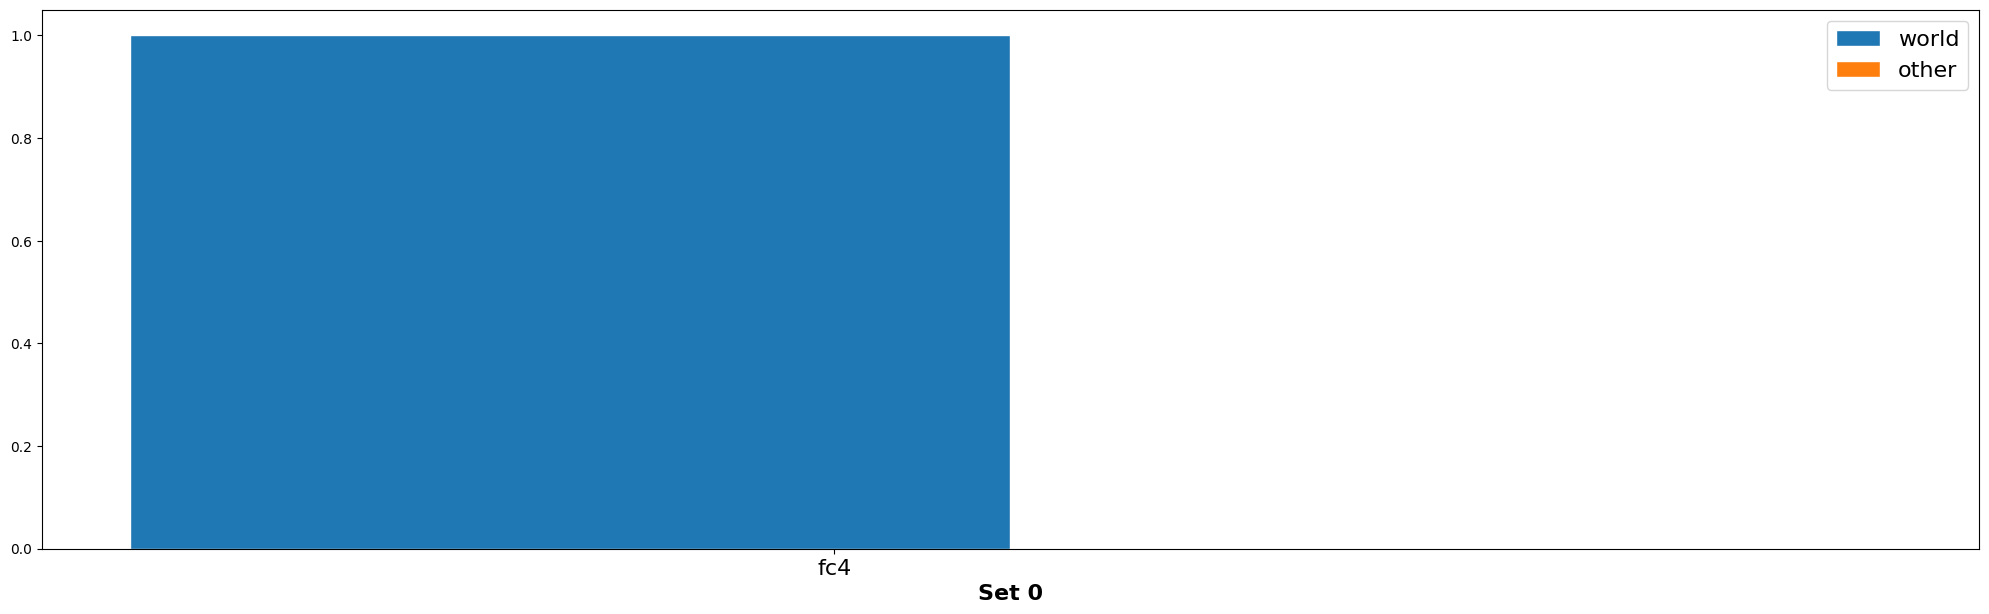

In [103]:
plot_tcav_scores(experimental_sets, positive_interpretations, ['fc4'], score_type='sign_count')